In [8]:
import torch
import torch.nn as nn
from torchvision import datasets, models, transforms
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data import Dataset, DataLoader
import os
from PIL import Image
from torchvision import transforms
from tqdm import tqdm
from sklearn.metrics import accuracy_score, f1_score, roc_curve, roc_auc_score
import matplotlib.pyplot as plt

In [9]:
# Image transformations
normal_transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize to 224x224 pixels
    transforms.ToTensor(),  # Convert to PyTorch Tensor
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])  # Normalization
])

mirror_transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize to 224x224 pixels
    transforms.RandomVerticalFlip(p=1), # Make a mirror image, should perfect fit the golf swing case as lefty become righty and vice versa
    transforms.ToTensor(),  # Convert to PyTorch Tensor
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])  # Normalization
])

# Video dataset class: a single video dataset would consist 9 sequence of frames with highlighted skeleton points and
# white/original background
class VideoDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.classes = sorted(os.listdir(root_dir))
        self.videos = []
        curr_vid_id = '0'
        curr_vid_list = []
        for c in self.classes:
            # somehow it reads the Mac .DS_store file...
            if c.startswith('.'):
                continue

            pro_am, vid_id, swing_pos, confidence_score, _ = c.split('_')

            if vid_id == curr_vid_id:
                curr_vid_list.append((vid_id, swing_pos, float(confidence_score), pro_am, os.path.join(root_dir, c)))
            else:
                if len(curr_vid_list) != 0:
                    self.videos.append(list(curr_vid_list))
                curr_vid_id = vid_id
                curr_vid_list.clear()
                curr_vid_list.append((vid_id, swing_pos, float(confidence_score), pro_am, os.path.join(root_dir, c)))

        if len(curr_vid_list) != 0:
            self.videos.append(list(curr_vid_list))

    def __len__(self):
        return len(self.videos)

    def __getitem__(self, idx):
        frames = []
        for frame in self.videos[idx]:
            vid_id, swing_position, confidence_score, pro_am, img_path = frame
            img = Image.open(img_path)
            if self.transform:
                img = self.transform(img)
            frames.append(img)

        # Stack frames into one tensor
        # TODO: figure out a way to encode swing_position & confidence score
        video = torch.hstack(frames)
        label = 1 if (pro_am == 'pro') else 0
        return video, label

In [10]:
# currently using 3D skeleton points w/ white background as training examples
positive_dir = '../ai_golf_swing_dataset/pro_swing-position_skeleton_white-background_frames'
negative_dir = '../ai_golf_swing_dataset/amateur_swing-position_skeleton_white-background_frames'
positive_dataset = VideoDataset(positive_dir, normal_transform) # size 1400
negative_dataset = VideoDataset(negative_dir, normal_transform) # size 500
negative_dataset_mirror = VideoDataset(negative_dir, mirror_transform) # size 500
full_dataset = torch.utils.data.ConcatDataset([positive_dataset, negative_dataset, negative_dataset_mirror])

# Split the data into training and validation
# 70% train, 20% dev, 10% test
train_size = int(0.7 * len(full_dataset))
val_size = int(0.2 * len(full_dataset))
test_size = len(full_dataset) - train_size - val_size
train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(full_dataset, [train_size, val_size, test_size])

# Create dataloaders
train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=16, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=16, shuffle=True)

# Load pre-trained model
model = models.resnet50(pretrained=True)

# Freeze the model parameters
for param in model.parameters():
    param.requires_grad = False

# Replace the final layer for binary classification
model.fc = nn.Linear(model.fc.in_features, 1)

# Use GPU if available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Loss function and optimizer
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.fc.parameters(), lr=0.001)


/Users/zihan.yi/opt/anaconda3/envs/openmmlab/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/zihan.yi/opt/anaconda3/envs/openmmlab/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


train-0: 100%|██████████| 85/85 [06:48<00:00,  4.81s/it]


Epoch:  0 Training Loss:  31.56016816198826 , Training Acc:  0.8564026646928201
Finishing Training the model. Now starting to evaluate...


validation: 100%|██████████| 13/13 [00:54<00:00,  4.19s/it]

Dev Set Acc:  0.9067357512953368
Dev Set F1 score:  0.9387755102040817


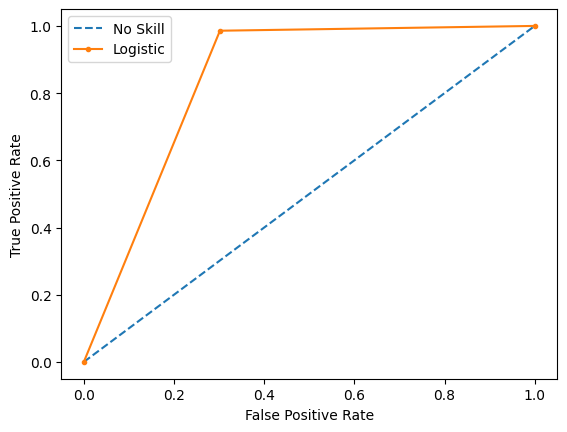

AUC: 0.842


train-1: 100%|██████████| 85/85 [06:54<00:00,  4.88s/it]


Epoch:  1 Training Loss:  26.846774250268936 , Training Acc:  0.8993338267949667
Finishing Training the model. Now starting to evaluate...


validation: 100%|██████████| 13/13 [00:53<00:00,  4.09s/it]

Dev Set Acc:  0.9326424870466321
Dev Set F1 score:  0.9537366548042705


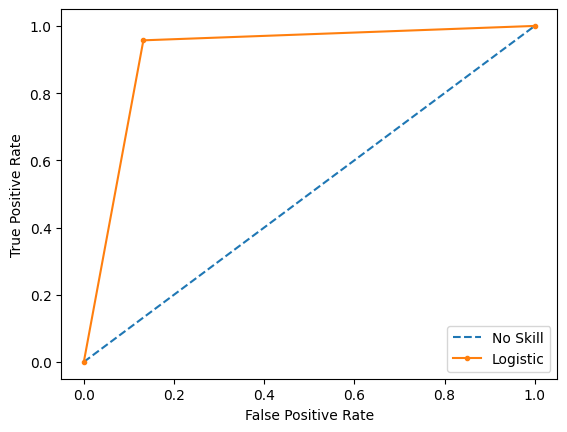

AUC: 0.913


train-2: 100%|██████████| 85/85 [06:56<00:00,  4.89s/it]


Epoch:  2 Training Loss:  24.72784373164177 , Training Acc:  0.9126572908956329
Finishing Training the model. Now starting to evaluate...


validation: 100%|██████████| 13/13 [00:54<00:00,  4.16s/it]

Dev Set Acc:  0.9326424870466321
Dev Set F1 score:  0.9543859649122807


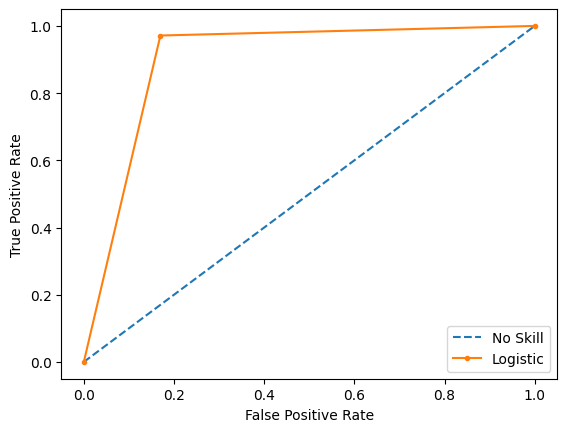

AUC: 0.901


train-3: 100%|██████████| 85/85 [06:53<00:00,  4.87s/it]


Epoch:  3 Training Loss:  23.732723467051983 , Training Acc:  0.9126572908956329
Finishing Training the model. Now starting to evaluate...


validation: 100%|██████████| 13/13 [00:53<00:00,  4.15s/it]

Dev Set Acc:  0.9326424870466321
Dev Set F1 score:  0.9543859649122807


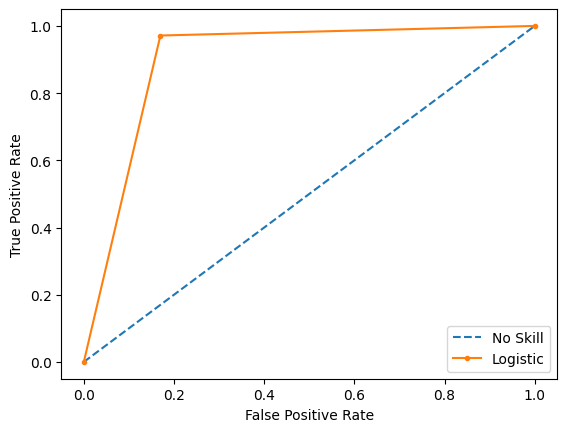

AUC: 0.901


train-4: 100%|██████████| 85/85 [06:52<00:00,  4.86s/it]


Epoch:  4 Training Loss:  22.242743745446205 , Training Acc:  0.927461139896373
Finishing Training the model. Now starting to evaluate...


validation: 100%|██████████| 13/13 [00:54<00:00,  4.18s/it]

Dev Set Acc:  0.9378238341968912
Dev Set F1 score:  0.9583333333333333


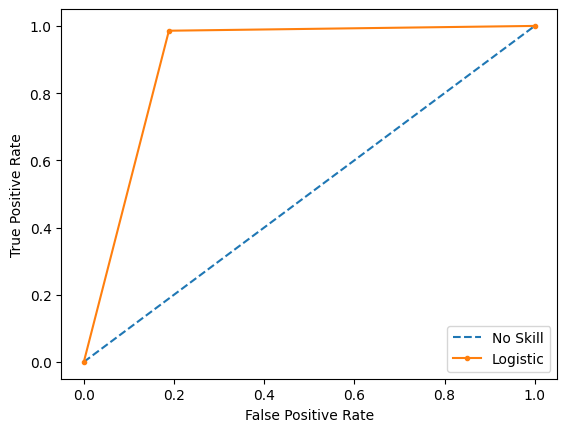

AUC: 0.899


train-5: 100%|██████████| 85/85 [07:00<00:00,  4.95s/it]


Epoch:  5 Training Loss:  21.758197106420994 , Training Acc:  0.9222797927461139
Finishing Training the model. Now starting to evaluate...


validation: 100%|██████████| 13/13 [00:54<00:00,  4.19s/it]

Dev Set Acc:  0.9378238341968912
Dev Set F1 score:  0.9583333333333333


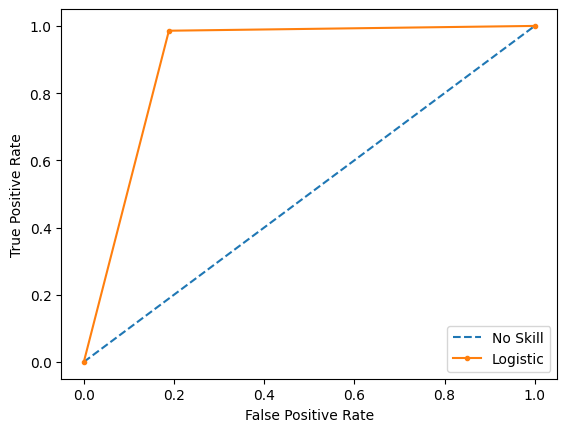

AUC: 0.899


train-6: 100%|██████████| 85/85 [06:53<00:00,  4.87s/it]


Epoch:  6 Training Loss:  20.57792977243662 , Training Acc:  0.9252405625462621
Finishing Training the model. Now starting to evaluate...


validation: 100%|██████████| 13/13 [00:54<00:00,  4.21s/it]

Dev Set Acc:  0.9430051813471503
Dev Set F1 score:  0.9616724738675958


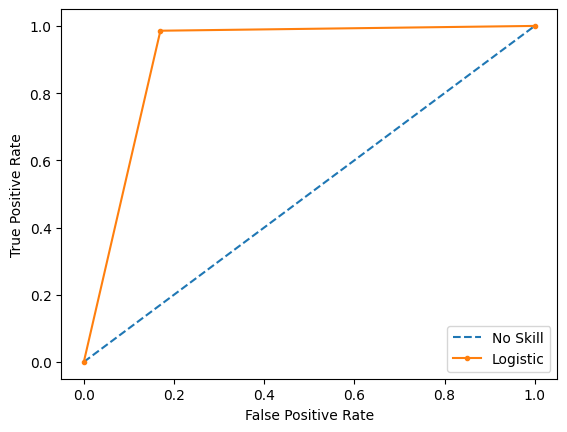

AUC: 0.908


train-7: 100%|██████████| 85/85 [06:51<00:00,  4.84s/it]


Epoch:  7 Training Loss:  20.20539554953575 , Training Acc:  0.930421909696521
Finishing Training the model. Now starting to evaluate...


validation: 100%|██████████| 13/13 [00:53<00:00,  4.12s/it]

Dev Set Acc:  0.9430051813471503
Dev Set F1 score:  0.9616724738675958


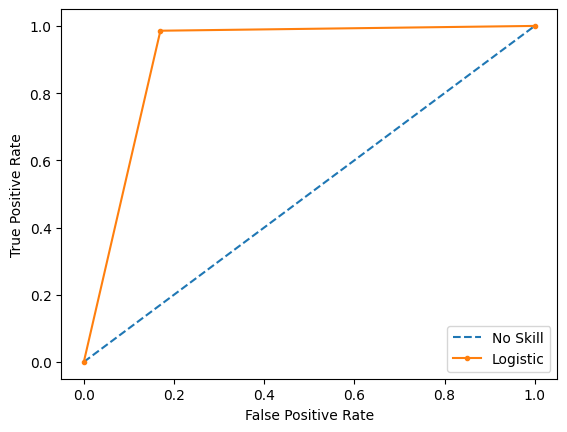

AUC: 0.908


train-8: 100%|██████████| 85/85 [06:55<00:00,  4.89s/it]


Epoch:  8 Training Loss:  20.49739706516266 , Training Acc:  0.921539600296077
Finishing Training the model. Now starting to evaluate...


validation: 100%|██████████| 13/13 [00:54<00:00,  4.15s/it]

Dev Set Acc:  0.9481865284974094
Dev Set F1 score:  0.9645390070921985


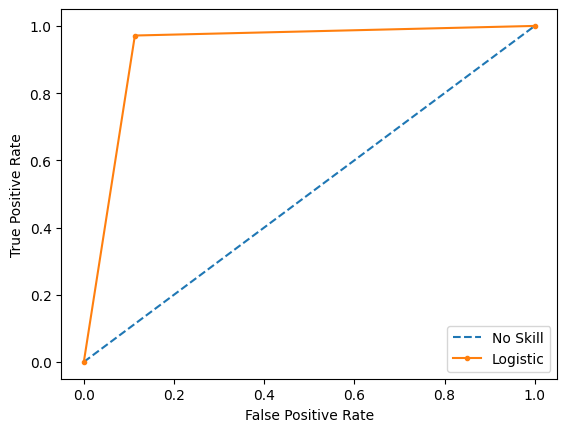

AUC: 0.929


train-9: 100%|██████████| 85/85 [06:44<00:00,  4.75s/it]


Epoch:  9 Training Loss:  20.293587870895863 , Training Acc:  0.923760177646188
Finishing Training the model. Now starting to evaluate...


validation: 100%|██████████| 13/13 [00:54<00:00,  4.22s/it]

Dev Set Acc:  0.9533678756476683
Dev Set F1 score:  0.9679715302491102


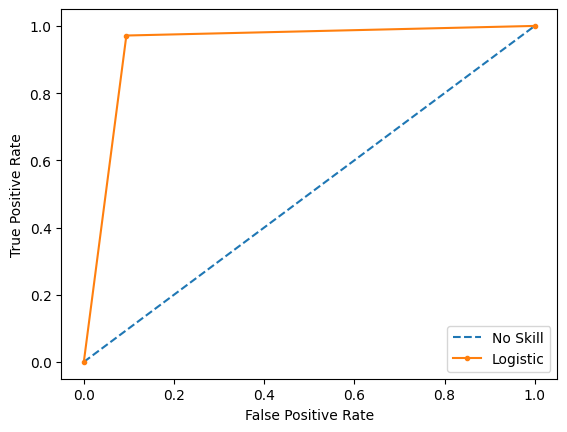

AUC: 0.939
Overall Best Dev Acc:  0.9533678756476683


In [16]:
best_dev_acc = 0.0
best_model = None

TRAINING_EPOCH = 10
# threshold probs for classifier to predict true
threshold = 0.5

# Train the model
training_loss_history = []
training_acc_list = []
val_acc_list = []
for epoch in range(TRAINING_EPOCH):  # for 10 epochs

    # Train mode
    model.train()
    train_loss = 0.0
    y_train_true = []
    y_train_pred = []
    for inputs, labels in tqdm(train_dataloader, desc=f'train-{epoch}', disable=False):
        inputs = inputs.to(device)
        labels = labels.to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs.view(-1), labels.float())

        probs = torch.sigmoid(outputs)
        preds = (probs > threshold).int().reshape(labels.shape)
        y_train_true.extend(labels.tolist())
        y_train_pred.extend(preds.tolist())

        # Backward pass and optimize
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    train_acc = accuracy_score(y_train_true, y_train_pred)
    training_loss_history.append(train_loss)
    training_acc_list.append(train_acc)
    print('Epoch: ', epoch, 'Training Loss: ', train_loss, ', Training Acc: ', train_acc)
    print('Finishing Training the model. Now starting to evaluate...')

    # Validate the model
    model.eval()  # Set the model to evaluation mode

    y_val_true = []
    y_val_pred = []
    with torch.no_grad():
        for inputs, labels in tqdm(val_dataloader, desc=f'validation', disable=False):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            probs = torch.sigmoid(outputs)
            preds = (probs > threshold).int().reshape(labels.shape)
            y_val_true.extend(labels.tolist())
            y_val_pred.extend(preds.tolist())

    f1 = f1_score(y_val_true, y_val_pred, average='binary')
    val_acc = accuracy_score(y_val_true, y_val_pred)
    val_acc_list.append(val_acc)

    print('Dev Set Acc: ', val_acc)
    print('Dev Set F1 score: ', f1)

    # calculate roc curves
    fpr, tpr, thresholds = roc_curve(y_val_true, y_val_pred)

    # plot the roc curve for the model
    plt.plot([0, 1], [0, 1], linestyle='--', label='No Skill')
    plt.plot(fpr, tpr, marker='.', label='Logistic')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend()
    plt.show()

    # compute AUC score
    auc = roc_auc_score(y_val_true, y_val_pred)
    print('AUC: %.3f' % auc)

    if val_acc > best_dev_acc:
        best_dev_acc = val_acc
        best_model = 'pro_am_classifier_epoch_{}.pth'.format(epoch)
        # Save the curr best model
        torch.save(model.state_dict(), best_model)

print('Overall Best Dev Acc: ', best_dev_acc)

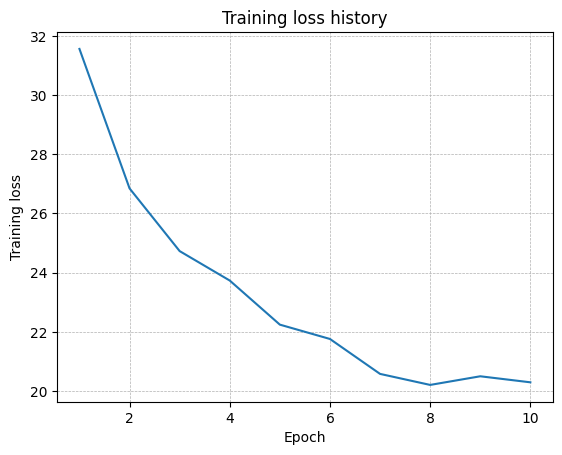

In [17]:
# TODO: training loss vs. epoch curve
plt.plot(list(range(1, 11)), training_loss_history)
plt.title("Training loss history")
plt.xlabel("Epoch")
plt.ylabel("Training loss")
plt.grid(linestyle='--', linewidth=0.5)
plt.show()

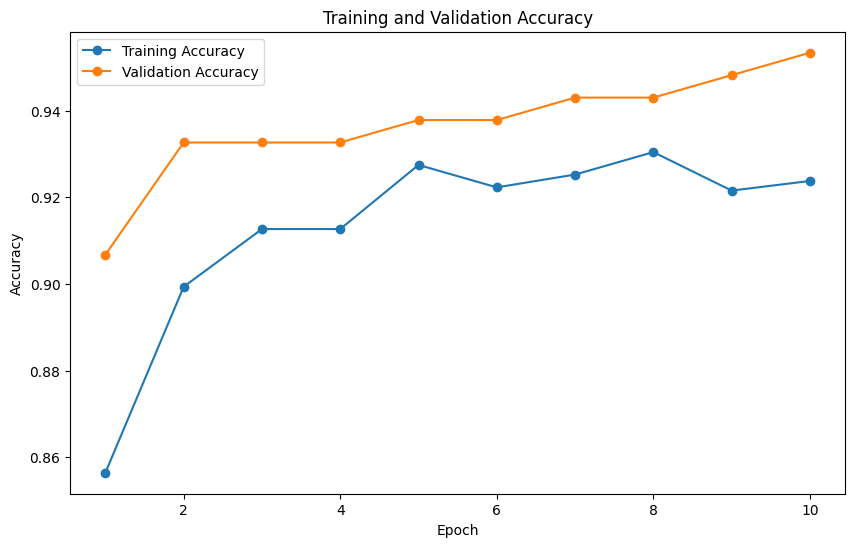

In [20]:
# TODO: training acc + dev set acc vs. epoch
plt.figure(figsize=(10, 6))

# Plot training accuracy
plt.plot(list(range(1, 11)), training_acc_list, label='Training Accuracy', marker='o')

# Plot validation accuracy
plt.plot(list(range(1, 11)), val_acc_list, label='Validation Accuracy', marker='o')

# Label axes and title
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

# Show legend to differentiate the lines
plt.legend()

# Display the plot
plt.show()

In [24]:
# test set validation
print('Starting to evaluate test set...')

print('Loading existing best model ', best_model)

# Load pre-trained model
model = models.resnet50(pretrained=True)

# Freeze the model parameters
for param in model.parameters():
    param.requires_grad = False

# Replace the final layer for binary classification
model.fc = nn.Linear(model.fc.in_features, 1)

model.load_state_dict(torch.load(best_model))
model.to(device)
model.eval()  # Set the model to evaluation mode

# threshold probs for classifier to predict true
threshold = 0.5

y_val_true = []
y_val_pred = []
with torch.no_grad():
    for inputs, labels in tqdm(test_dataloader, desc=f'test', disable=False):
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)
        probs = torch.sigmoid(outputs)
        preds = (probs > threshold).int().squeeze()
        y_val_true.extend(labels.tolist())
        y_val_pred.extend(preds.tolist())

    print('Test set accuracy: ', accuracy_score(y_val_true, y_val_pred))

Starting to evaluate test set...
Loading existing best model  pro_am_classifier_epoch_9.pth


/Users/zihan.yi/opt/anaconda3/envs/openmmlab/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/zihan.yi/opt/anaconda3/envs/openmmlab/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
test: 100%|██████████| 25/25 [01:47<00:00,  4.29s/it]

Test set accuracy:  0.9534883720930233
